# 샌프란 시스코 범죄 데이터 분석

### 목차

1. 범죄 유형별 분석
    1. 유형별 발생건수
    1. 발생 비율
    1. Larceny/Theft(이하 절도) 해결상태



2. 샌프란 시스코의 절도범죄 추이
    1. 년도별
    1. 계절별
    1. 일별
    1. 시간별
    
    
    
3. 세부 구역별 절도 범죄 분석
    1. 절도 우발 관할지역 분석 (Southern, Nothernm Central, Mission 지역 기준)
        1. 관할 구역기준 (PdDistrict 별로)
        2. 관할 구역 세분화 기준 (각 관할별로 100개 구역 분할)
    2. 연도별 분석, 계절, 월, 시간
        1. 전체 범죄 와 절도 범죄 추이 비교
        2. 월, 요일, 시간
4. 결론
    1. 그래서 어디에 인력을 배치해야한다 등등

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import folium 
from folium.plugins import HeatMap


plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='darkgrid')

__데이터 로드__

In [2]:
pd.set_option("display.max_columns", 100)
df = pd.read_csv("data/train_pre.csv")
df.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  Year  Month  Day  Hour  Min is_Weekday  Season  \
0 -122.425892  37.774599  2015      5   13    23   53         평일  spring   
1 -122.425892  37.774599  2015      5   13    23   53         평일  spring   
2 -122.424363  37.800414  2015      5   13    23   33         평일  spring   
3 -122.426995  37.800873  2015      5   13    23   30         평일  spring   
4 -122.438738  37.771541  2015      5   13    23   30         평일  spring   

  is_Weeked  
0   weekday  
1   weekday  
2   weekday  
3   weekday  
4   weekday

# 1. 범죄 유형별 분석

### a. 범죄 유형별 범죄 빈도

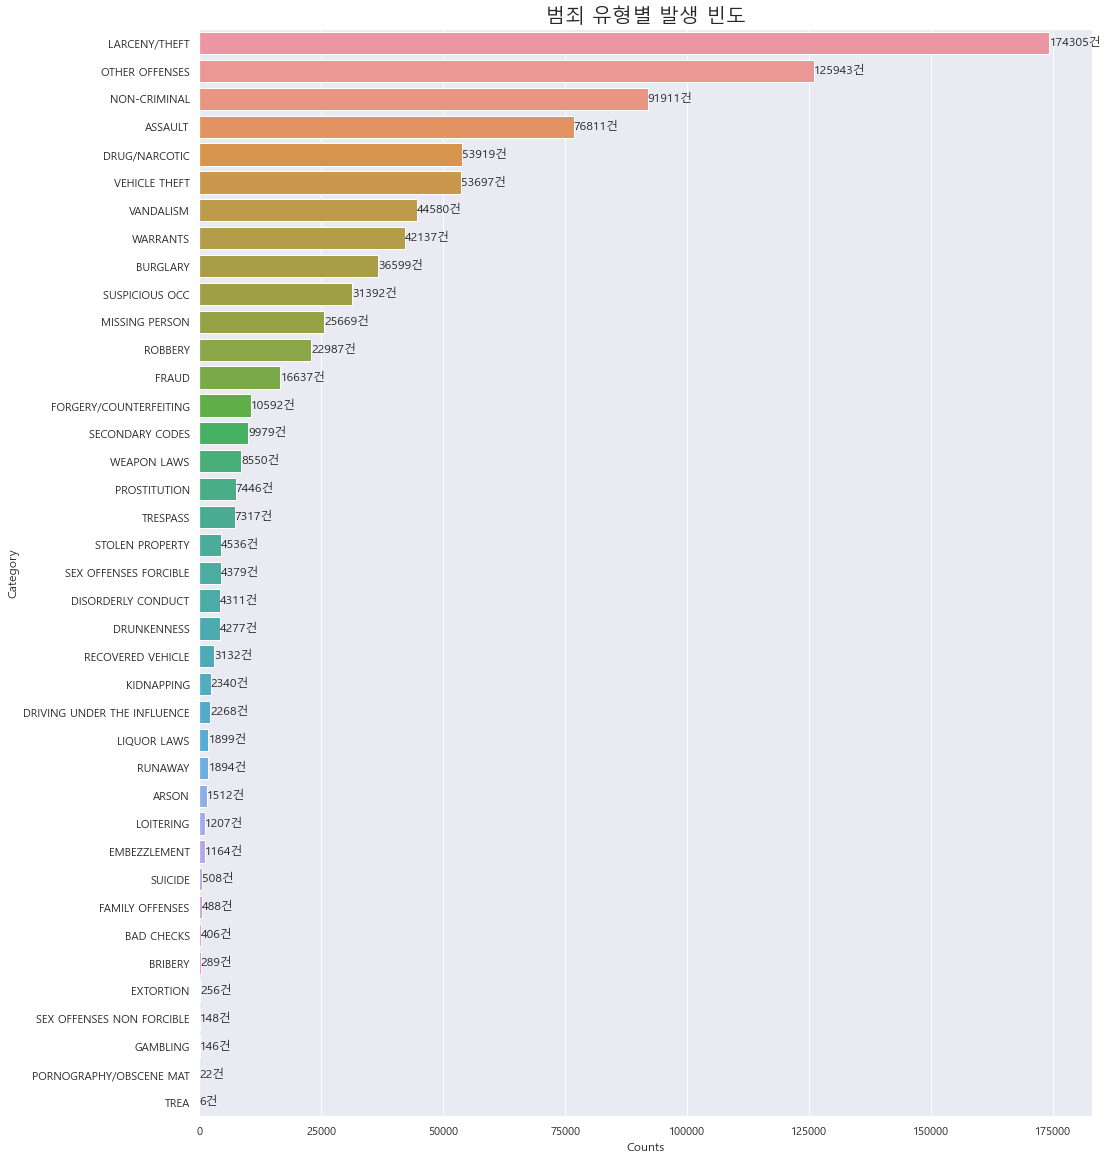

In [3]:
group = df.groupby(["Category"])[["Dates"]].count().sort_values(by = "Dates",ascending = False)
plt.figure(figsize = (16,20))
ax = sns.countplot(data = df, y = "Category", order = df['Category'].value_counts().index)

# 레이블
ax.bar_label(ax.containers[0], fmt='%.0f건')

# 그래프 제목
plt.title("범죄 유형별 발생 빈도", fontsize = 20)

# 축 이름 바꾸기
plt.xlabel("Counts")

plt.show()

>1. OTHER OFFENCE나 non-criminal은 제외하기로 하자
    1. Other Offence : 기타 범죄
    1. Non-Criminal : 교통 법규위반, 자연재해 등 가해자가 특정되지 않는 범죄

### b. 절도 범죄 발생 비율

In [4]:
group = group.drop(["OTHER OFFENSES","NON-CRIMINAL"], axis = 0)
group_per = group/group.sum()*100
# group_per[:10]

In [5]:
# 절도 범죄와 이외 범죄 비율로 분류
a = pd.DataFrame(group_per[1:].sum().values, index = ["OTHERS"], columns = ["Dates"])
group2 = group_per[:1]
group2 = pd.concat([group2, a])
group2.rename(columns = {"Dates" : "Rate"}, inplace = True)

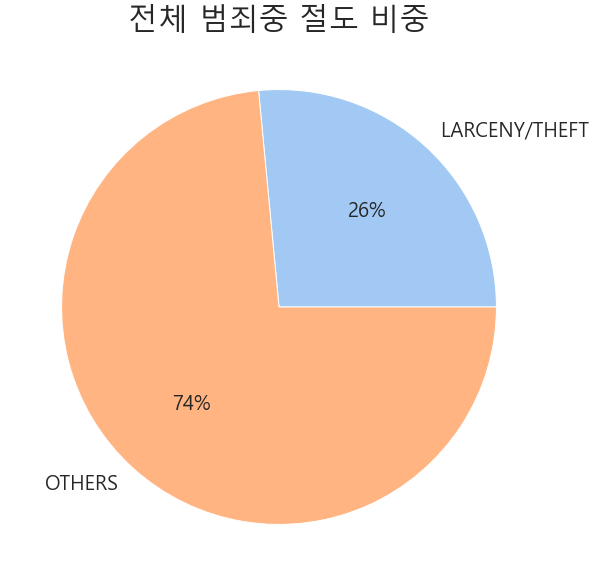

In [6]:
plt.figure(figsize = (16,10))

# 한글 폰트 설정
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='darkgrid')
colors = sns.color_palette('pastel')[0:5]

# 그래프
ax = plt.pie(data = group2, x = "Rate",labels = group2.index, colors = colors, autopct = '%.0f%%', textprops={'fontsize': 20})

# ax.bar_label(ax.containers[0], fmt='%.0f%%')

plt.title("전체 범죄중 절도 비중", fontsize = 30)


plt.show()

1. 전체 범죄중에 LARCENY/THEFT(절도, 도둑질)의 비중이 압도적으로 높음

### c. 절도 범죄 수사 현황

> NONE : 미해결 사건

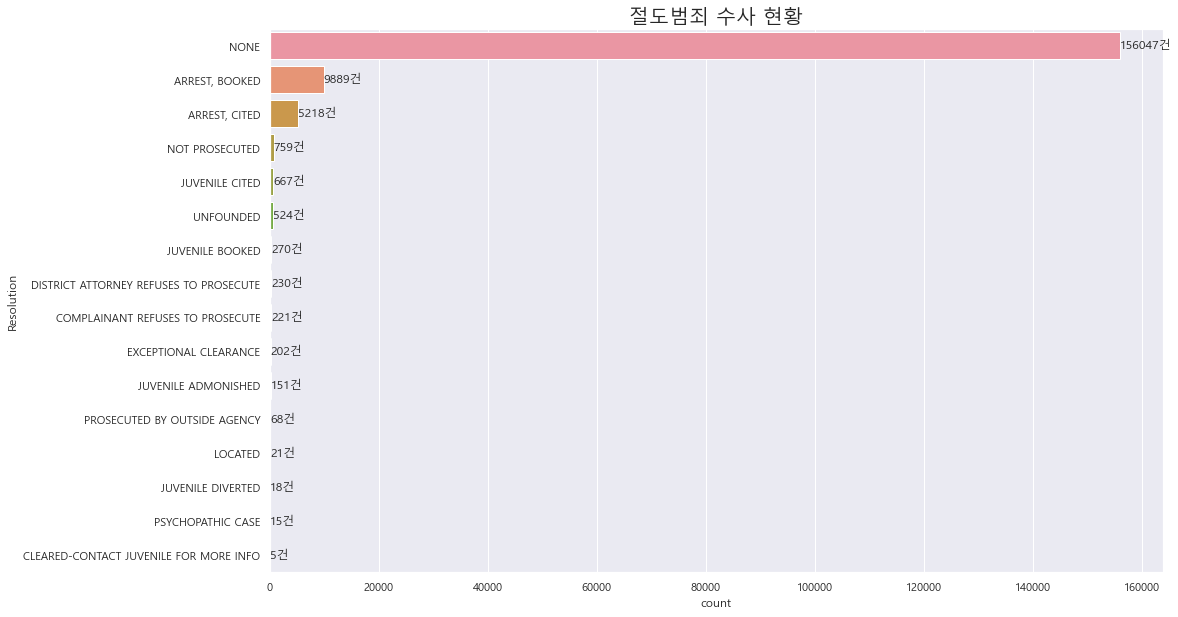

In [7]:
# 절도 범죄에 대한 수사 진행상황
df_larceny = df[df["Category"] == "LARCENY/THEFT"]

plt.figure(figsize = (16,10))
ax = sns.countplot(data = df_larceny, y =df_larceny["Resolution"], order = df_larceny["Resolution"].value_counts().index)
ax.bar_label(ax.containers[0], fmt='%.0f건')
plt.title('절도범죄 수사 현황',fontsize = 20)

plt.show()

__절도 범죄를 줄이기 위한 노력이 필요한 이유__
- 모든 범죄유형 중에서 앞도적으로 높은 범죄율을 보여주고 있음
- 대부분의 절도 범죄가 해결되지 않은 상태로 남아 있음
- 현행범이 아니면 검거하기 어려운 문제가 있음
- 때문에 고정된 경찰인력을 효율적으로 배치할 필요가 있음

In [8]:
# 절도 범죄만 추출
df_larceny = df[df["Category"] == "LARCENY/THEFT"]
df_larceny.reset_index(drop = True, inplace = True)

## 2. 샌프란시스코 절도 범죄 추이

### a. 연도별 분석

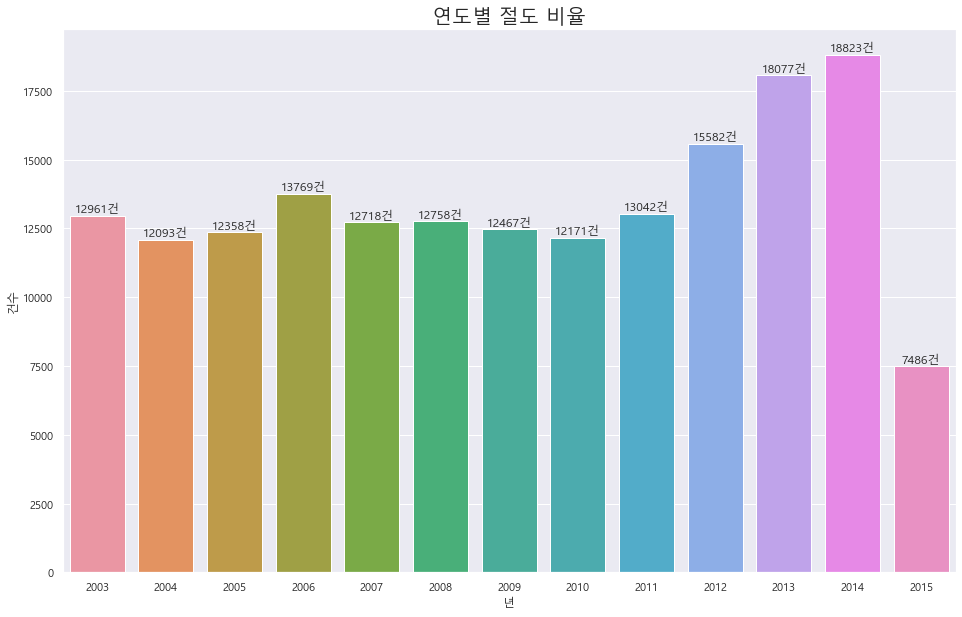

In [9]:
# 년별 절도 비율
plt.figure(figsize = (16,10))

colors = sns.color_palette('pastel')

ax = sns.countplot(data=df_larceny, x='Year')
ax.bar_label(ax.containers[0], fmt='%.0f건')
plt.title('연도별 절도 비율', fontsize = 20)
plt.xlabel('년')
plt.ylabel('건수')

plt.show()

> Q : 2015년은 특히 범죄율이 적은데 이유가 뭘까?  
A : 2015년 데이터는 5월까지만 존재한다.  


> 2012년 부터 급격히 절도 범죄율이 증가한다. 

In [10]:
# 2015년의 Month 피처 원소들을 추출
set(df_larceny[df_larceny["Year"] == 2015]["Month"])

{1, 2, 3, 4, 5}

### b. 계절별 분석

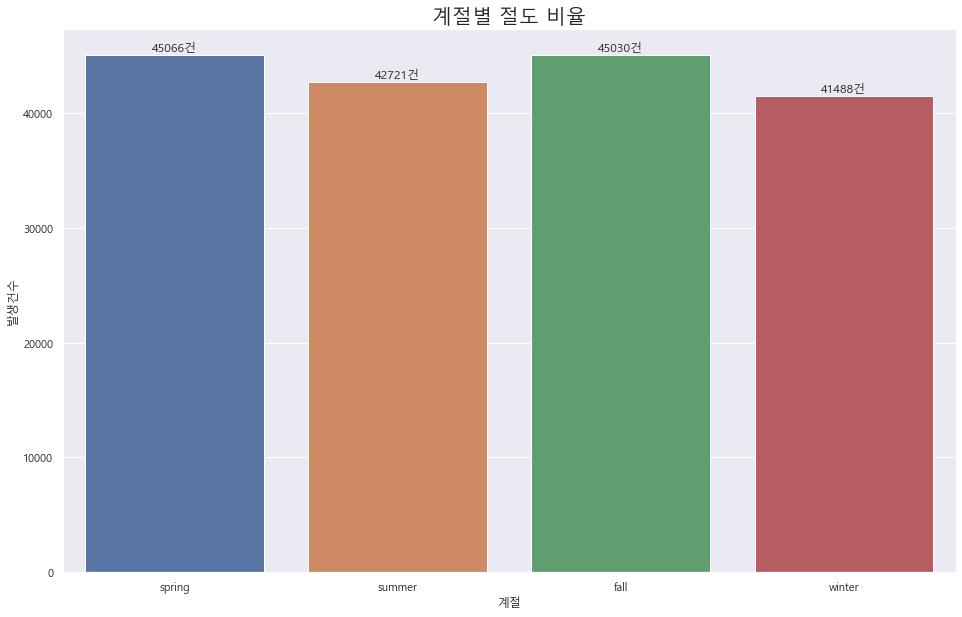

In [11]:
# 계절별 절도 비율
plt.figure(figsize = (16,10))
ax = sns.countplot(data=df_larceny, x='Season', order = ["spring", "summer", "fall", "winter"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title('계절별 절도 비율', fontsize = 20)
plt.xlabel('계절')
plt.ylabel('발생건수')
plt.show()

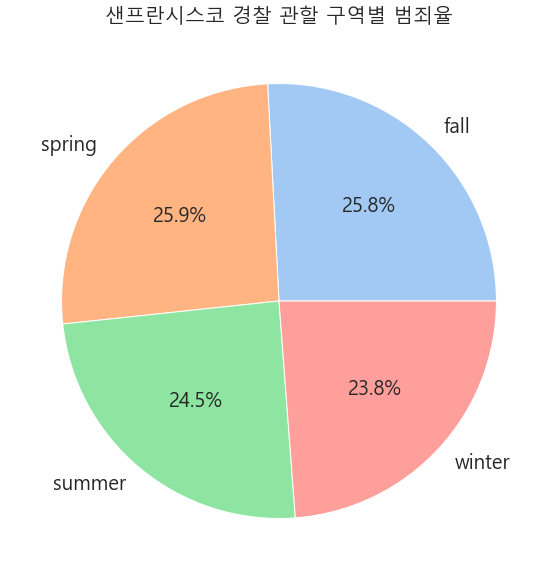

In [98]:
a = df_larceny.groupby(["Season"])[["Dates"]].count()
a = a/len(df_larceny)*100

plt.figure(figsize = (16,10))

# 한글 폰트 설정
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='darkgrid')

colors = sns.color_palette('pastel')[0:5]
ax = plt.pie(data = a, labels = a.index, x = "Dates", colors = colors, autopct = '%.1f%%',textprops={'fontsize': 20})

# ax.bar_label(ax.containers[0], fmt='%.0f%%')

plt.title("샌프란시스코 경찰 관할 구역별 범죄율", fontsize = 20)


plt.show()

__분석결과__
> 봄과 가을에 비교적 절도범죄 발생율이 높은 경향을 보이지만 전반적으로 큰 차이는 나지 않는다. 

### c. 시간별

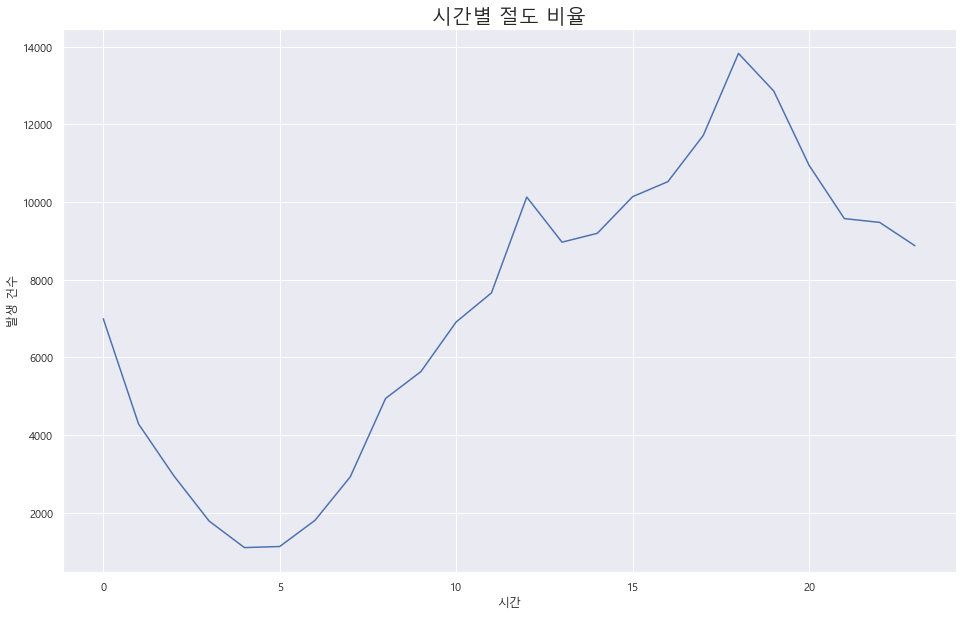

In [17]:
a = df_larceny.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,10))
sns.lineplot(data=a, x=a.index, y = "Dates")
plt.title('시간별 절도 비율', fontsize = 20)
plt.xlabel('시간')
plt.ylabel('발생 건수')
plt.show()

> 1. 12시 경을 기점으로 폭발적으로 범죄건수가 증가하다가 18시 경에 정점을 찍는다.  
2. 이러한 점을 미루어 보아 식사 시간 식당가 근처에서 절도 범죄가 많이 발생할것으로 추정

## 3. 구역별 절도 범죄 분석

__어느 지역에서 주로 범죄가 발생하는가?__

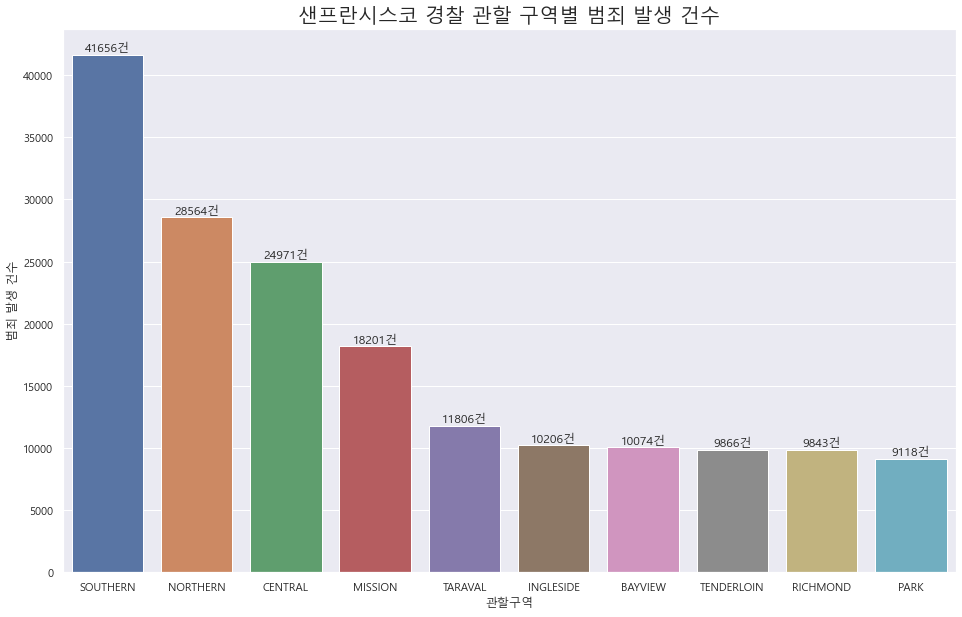

In [18]:
a = df_larceny.groupby(["PdDistrict"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False, inplace = True)

plt.figure(figsize = (16,10))

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='darkgrid')

ax = sns.barplot(data = a, x = a.index, y = "Dates", )

ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("샌프란시스코 경찰 관할 구역별 범죄 발생 건수", fontsize = 20)
plt.xlabel("관할구역")
plt.ylabel("범죄 발생 건수")

plt.show()

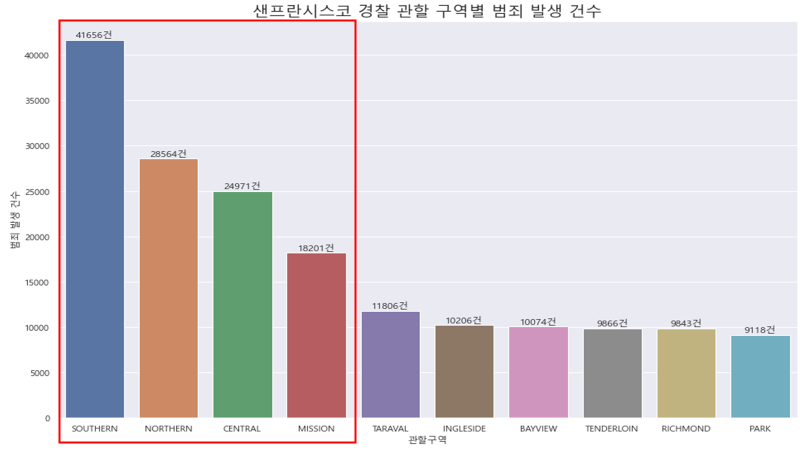

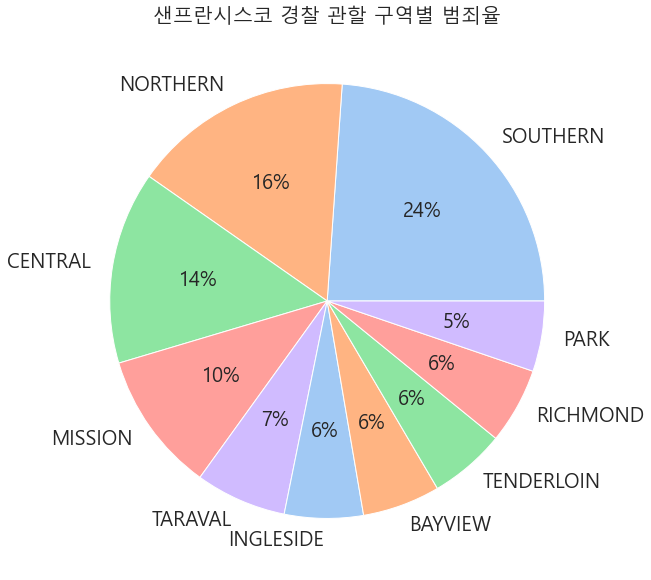

In [19]:
a = df_larceny.groupby(["PdDistrict"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False, inplace = True)
b = a/a.sum()*100

plt.figure(figsize = (16,10))

# 한글 폰트 설정
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='darkgrid')

colors = sns.color_palette('pastel')[0:5]
ax = plt.pie(data = b, x = "Dates",labels = b.index, colors = colors, autopct = '%.0f%%',textprops={'fontsize': 20})

# ax.bar_label(ax.containers[0], fmt='%.0f%%')

plt.title("샌프란시스코 경찰 관할 구역별 범죄율", fontsize = 20)


plt.show()

__주요 발생구역__

1. Southern
1. Northern
1. Central
1. Mission

In [20]:
# k-means clusturing을 통한 구역 분류
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def area_div(df, k):
    sc = StandardScaler()
    X = sc.fit_transform(df[["X", "Y"]])

    # 클러스터링 학습
    K = k
    kmeans = KMeans(n_clusters = K, random_state = 0)
    kmeans.fit(X)
    y_kmeans = kmeans.fit_predict(X)

    return y_kmeans

In [21]:
def crime_heatmap(df):
    df_area_group = df.groupby(["Area"])[["X","Y","Dates"]].agg({"X": "mean", "Y" : "mean", "Dates" : "count"})

    lat = df_area_group['Y'].mean()
    long = df_area_group["X"].mean()

    # 지도 띄우기
    m = folium.Map([lat, long], zoom_start = 14)

    HeatMap(zip(df_area_group["Y"], df_area_group["X"], df_area_group["Dates"]),
           min_opacity=0.1,
           max_val=5,
           radius=30,
           blur=15,
           max_zoom=5,
           color="red").add_to(m)
    
    for i in df_area_group.index:
        sub_lat = df_area_group.loc[i, 'Y']
        sub_long = df_area_group.loc[i, 'X']
        folium.Circle([sub_lat, sub_long], 
                      tooltip = i,
                       radius = 20,
                      icon=folium.Icon(color='green')
                     ).add_to(m)
    return m

### 1. Southern

### a. 관할구역(PdDistrict)별 분석

__Southern지역 요일, 시간별 분석__

In [22]:
df_southern = df_larceny[df_larceny["PdDistrict"] == "SOUTHERN"]
df_southern.reset_index(drop = True, inplace = True)

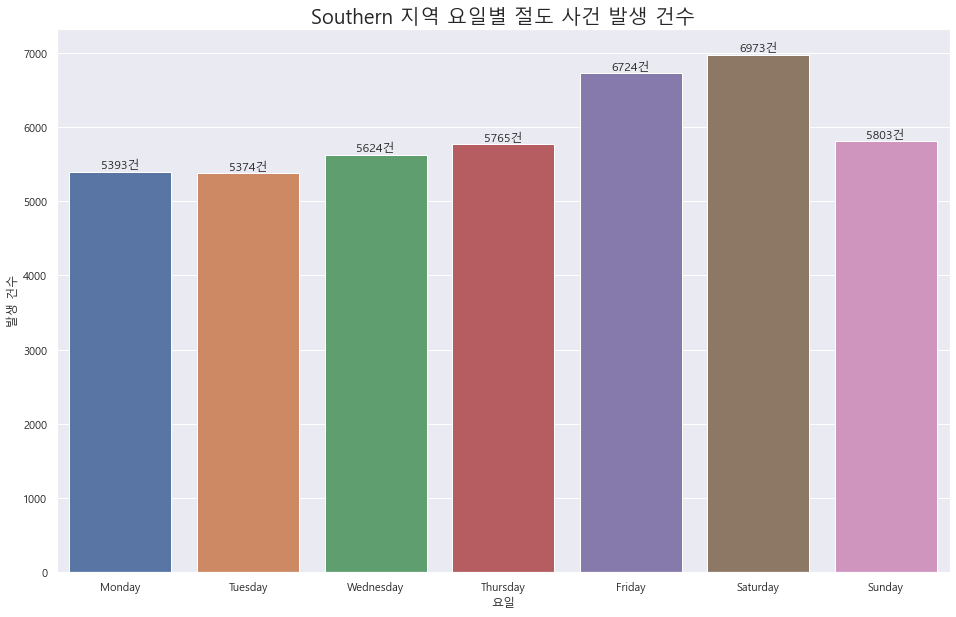

In [99]:
# southern 지역의 시간별 범죄 추이
a = df_southern.groupby(["DayOfWeek"])[["Dates"]].count()

plt.figure(figsize = (16,10))

ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Southern 지역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

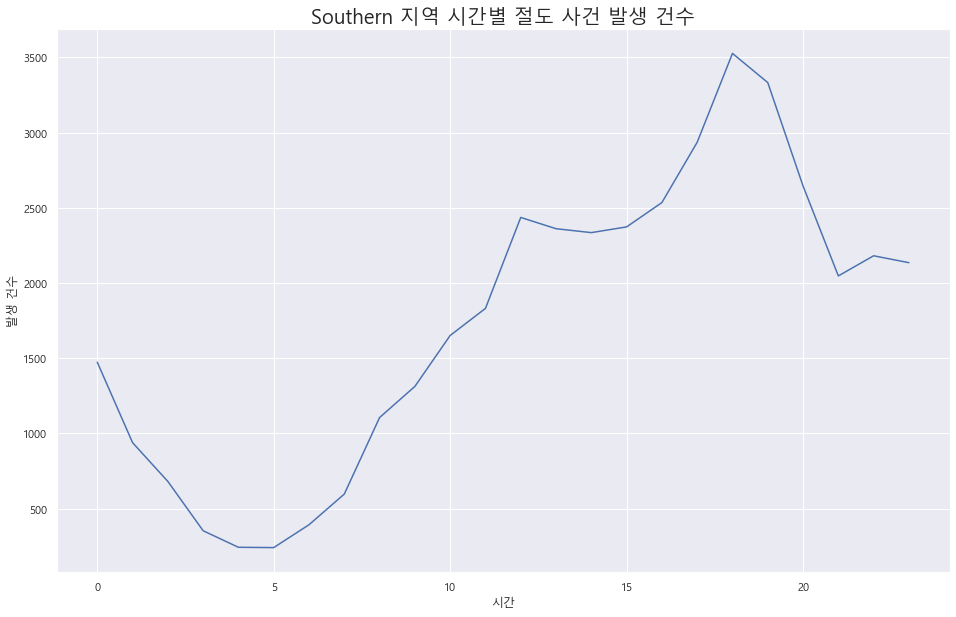

In [100]:
# southern 지역의 시간별 범죄 추이
a = df_southern.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,10))

sns.lineplot(data = a, x = a.index, y = "Dates")

plt.title("Southern 지역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()

### b. 세분화 구역 기준 분석(각 관할별로 100개 구역 분할)

__Southern구역 세분화 분석__

In [26]:
df_southern["Area"] = area_div(df_southern, 100)
crime_heatmap(df_southern)

C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\3498959233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_southern["Area"] = area_div(df_southern, 100)
C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\2233322824.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(zip(df_area_group["Y"], df_area_group["X"], df_area_group["Dates"]),


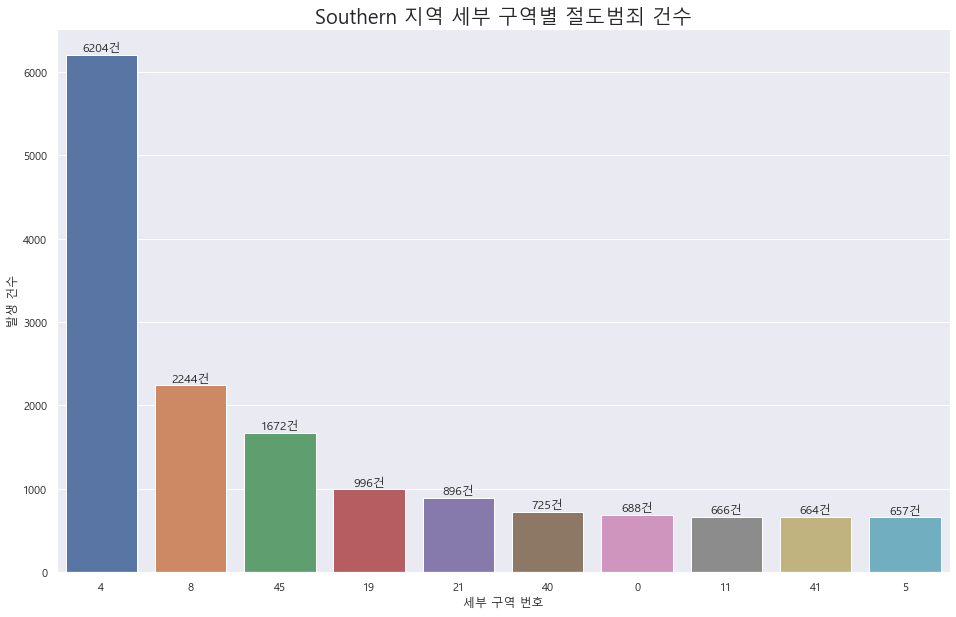

In [27]:
a = df_southern.groupby(["Area"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False,inplace = True)
a = a[:10]

plt.figure(figsize = (16, 10))
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = a.index)
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Southern 지역 세부 구역별 절도범죄 건수", fontsize = 20)
plt.xlabel("세부 구역 번호")
plt.ylabel("발생 건수")

plt.show()

__Southern__
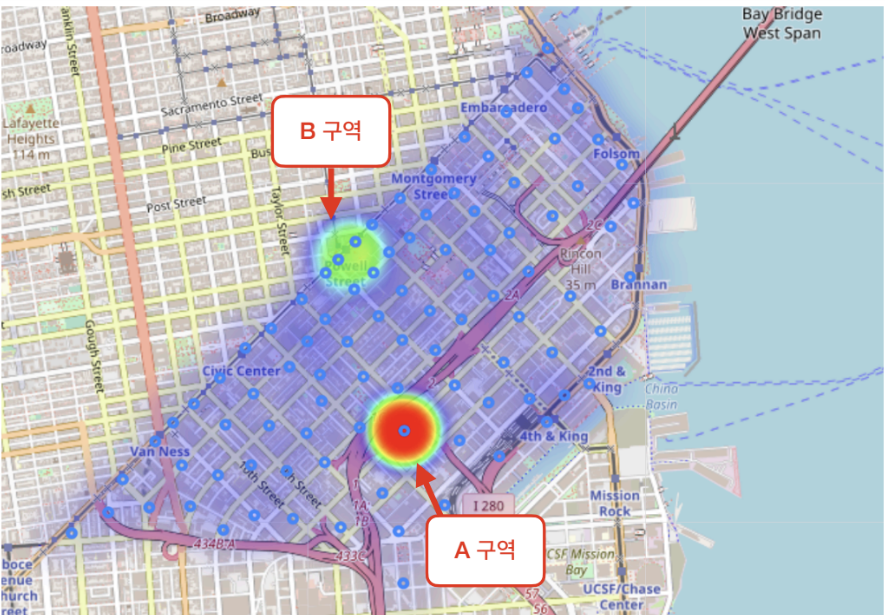

__절도 범죄 우발 거리__
1. A구역:4
1. B구역 : 8, 45

In [28]:
# Bryant Street
df_southern1 = df_southern[df_southern["Area"] == 4]
df_southern1.reset_index(drop = True, inplace = True)

# Powell Street
df_southern2 = df_southern[(df_southern["Area"] == 8) | (df_southern["Area"] == 45)]
df_southern2.reset_index(drop = True, inplace = True)

__요일별 분석__

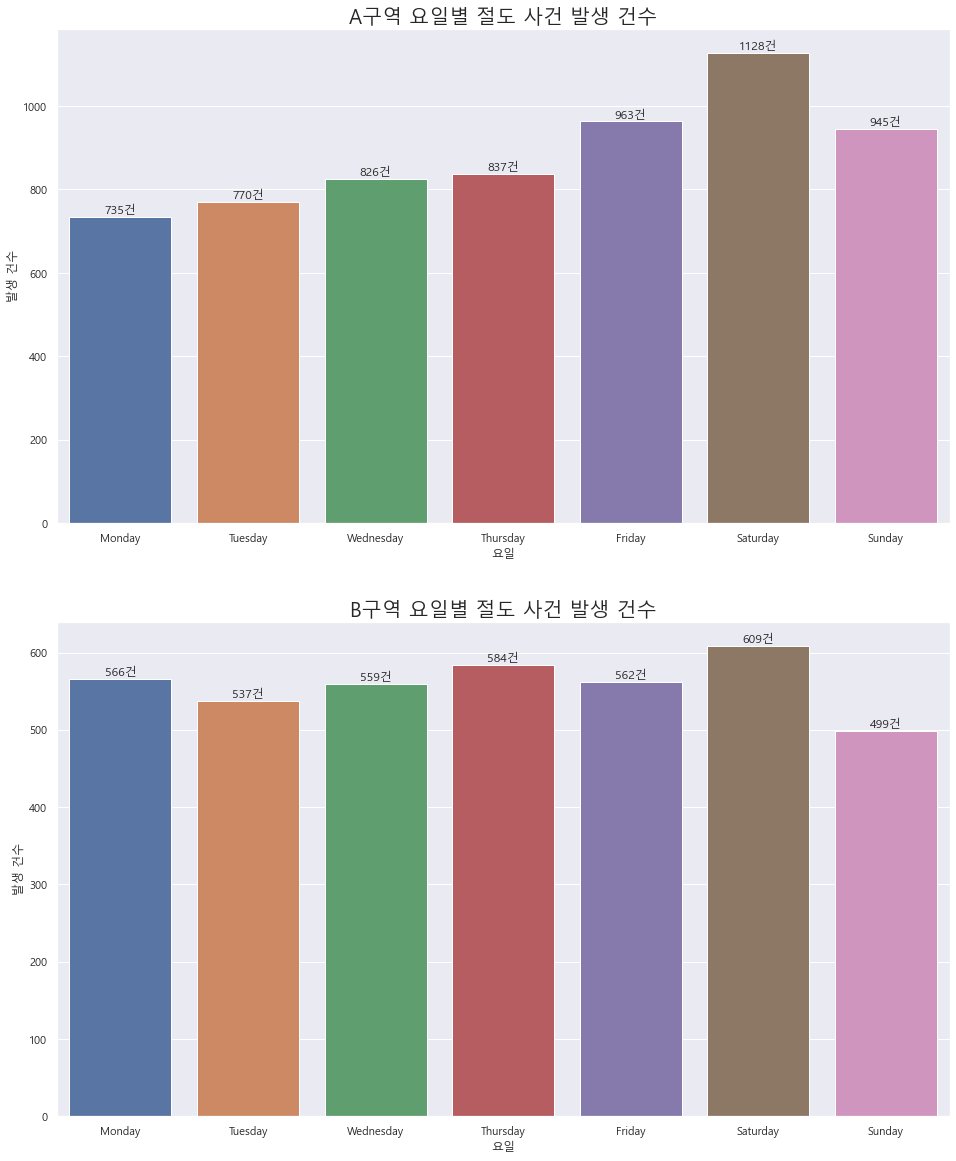

In [58]:
# southern 지역의 시간별 범죄 추이
a = df_southern1.groupby(["DayOfWeek"])[["Dates"]].count()
b = df_southern2.groupby(["DayOfWeek"])[["Dates"]].count()


plt.figure(figsize = (16,20))

# Bryant Street
plt.subplot(2,1,1)
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("A구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

# Powell Street
plt.subplot(2,1,2)
ax = sns.barplot(data = b, x = b.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("B구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

__시간별 분석__

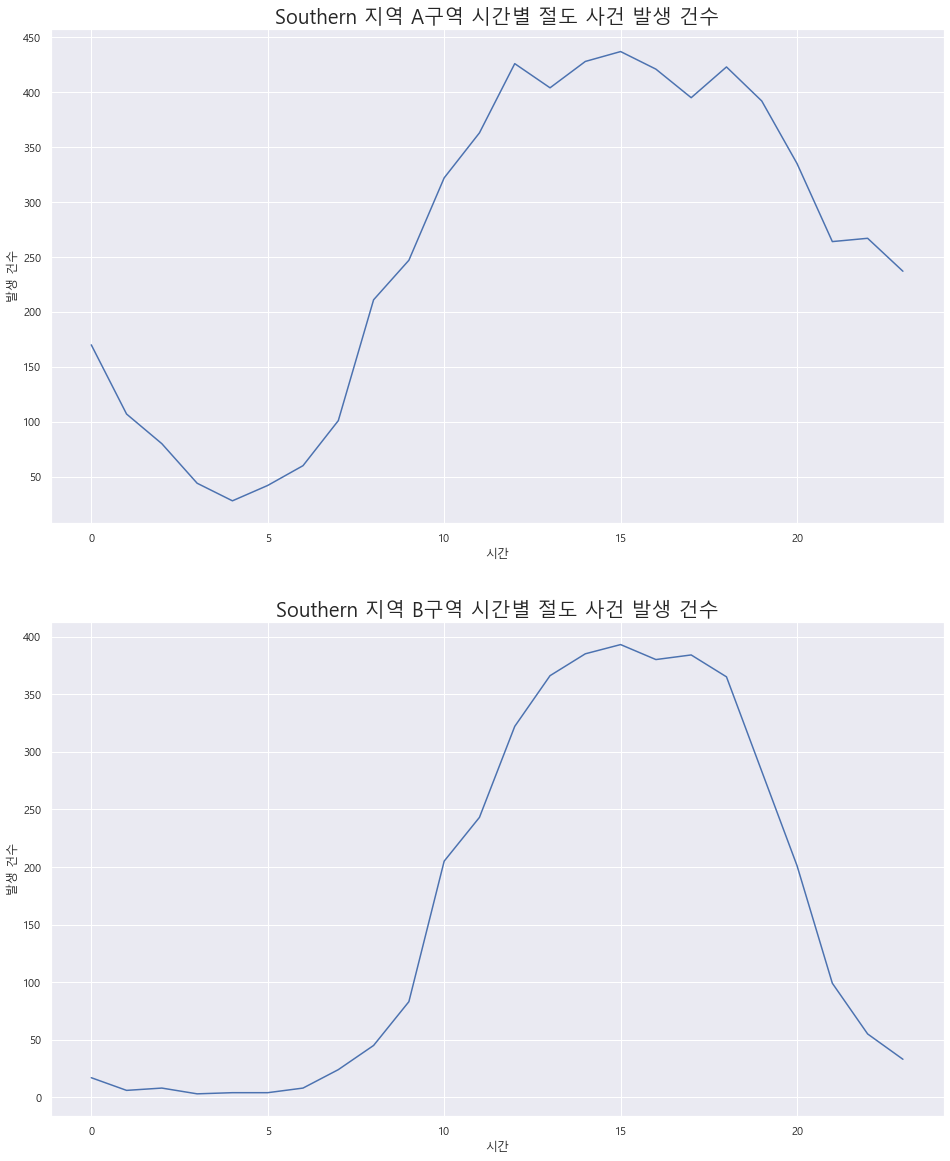

In [101]:
# southern 지역의 시간별 범죄 추이
a = df_southern1.groupby(["Hour"])[["Dates"]].count()
b = df_southern2.groupby(["Hour"])[["Dates"]].count()


plt.figure(figsize = (16,20))

# Bryant Street
plt.subplot(2,1,1)
ax = sns.lineplot(data = a, x = a.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Southern 지역 A구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

# Powell Street
plt.subplot(2,1,2)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Southern 지역 B구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()

## 2. Northern

### a. 관할구역별 분석

__Nothern 지역 요일, 시간별 분석__

In [31]:
df_northern = df_larceny[df_larceny["PdDistrict"] == "NORTHERN"]
df_northern.reset_index(drop = True, inplace = True)

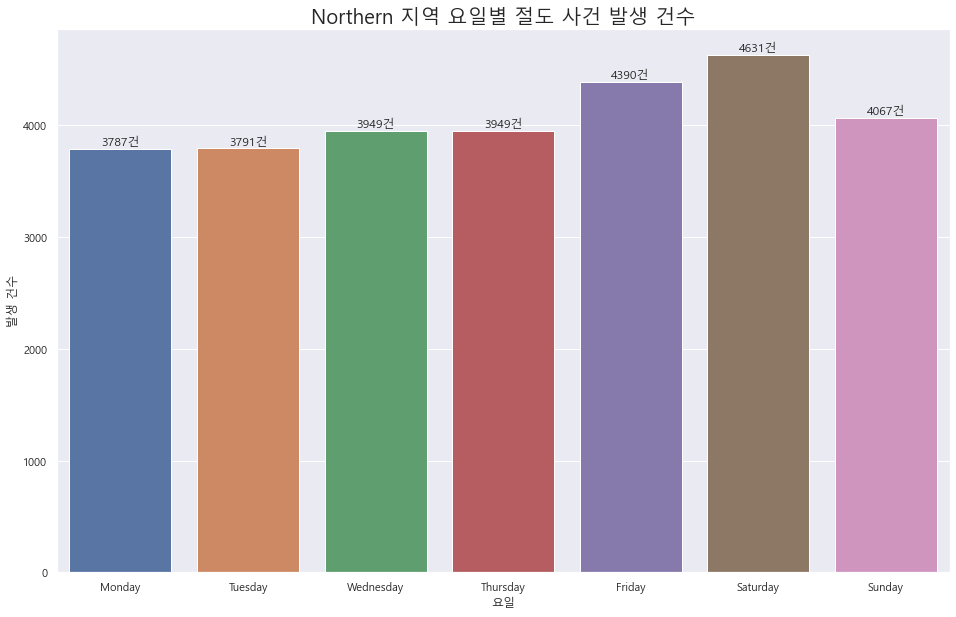

In [102]:
# southern 지역의 시간별 범죄 추이
a = df_northern.groupby(["DayOfWeek"])[["Dates"]].count()

plt.figure(figsize = (16,10))

ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Northern 지역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

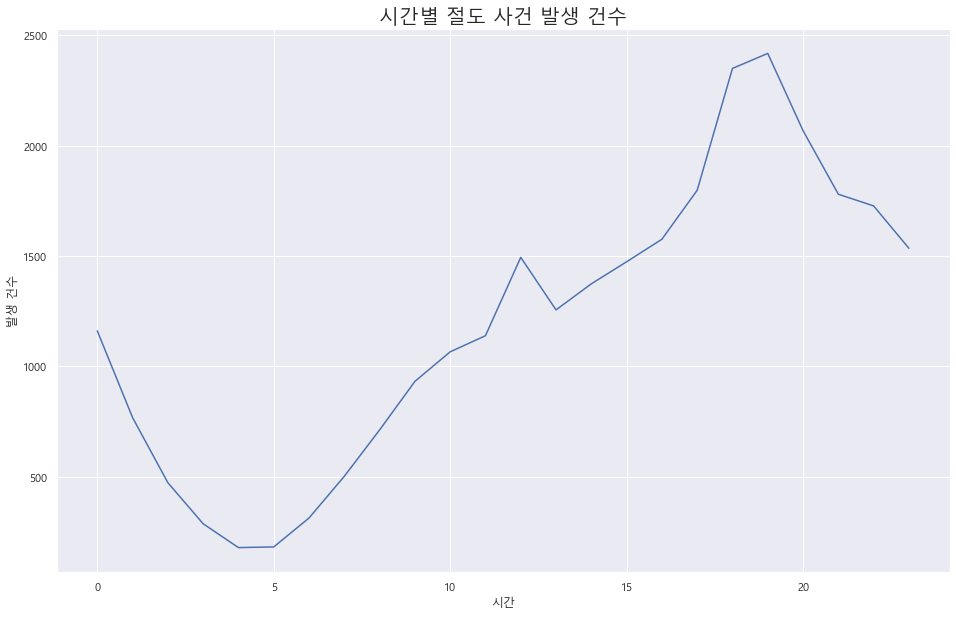

In [34]:
# southern 지역의 시간별 범죄 추이
a = df_northern.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,10))

sns.lineplot(data = a, x = a.index, y = "Dates")

plt.title("시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()

### b. 세분화 구역 기준 분석(각 관할별로 100개 구역 분할)

__Northern구역 세분화 분석__

In [35]:
df_northern = df_larceny[df_larceny["PdDistrict"] == "NORTHERN"]
df_northern.reset_index(drop = True, inplace = True)
df_northern["Area"] = area_div(df_northern, 100)
crime_heatmap(df_northern)

C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\1475034243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_northern["Area"] = area_div(df_northern, 100)
C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\2233322824.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(zip(df_area_group["Y"], df_area_group["X"], df_area_group["Dates"]),


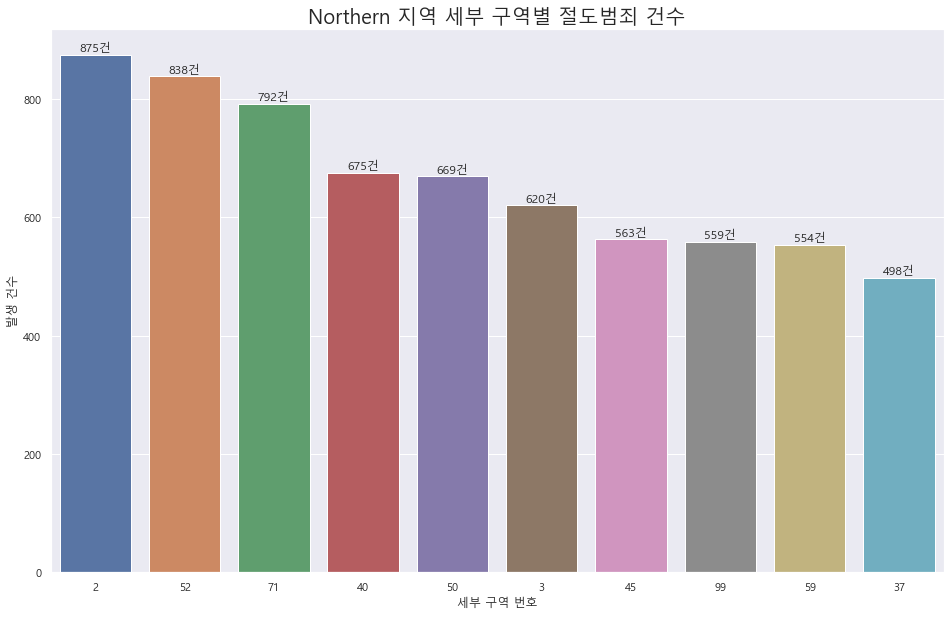

In [36]:
a = df_northern.groupby(["Area"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False,inplace = True)
a = a[:10]

plt.figure(figsize = (16, 10))
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = a.index)
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Northern 지역 세부 구역별 절도범죄 건수", fontsize = 20)
plt.xlabel("세부 구역 번호")
plt.ylabel("발생 건수")

plt.show()

__Northern__
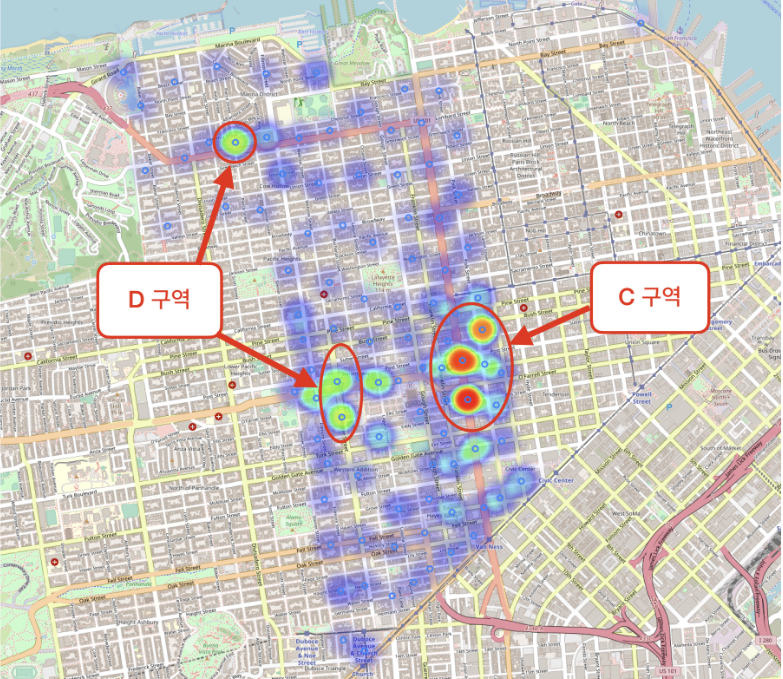

__절도 범죄 우발 구역__
1. C구역 : 2,52, 71
1. D구역 : 40, 50, 3

__요일별 분석__

In [37]:
df_northern1 = df_northern[(df_northern["Area"] == 2) | (df_northern["Area"] == 52) | (df_northern["Area"] == 71)]
df_northern1.reset_index(drop = True, inplace = True)

df_northern2 = df_northern[(df_northern["Area"] == 40) | (df_northern["Area"] == 50) | (df_northern["Area"] == 3)]
df_northern2.reset_index(drop = True, inplace = True)

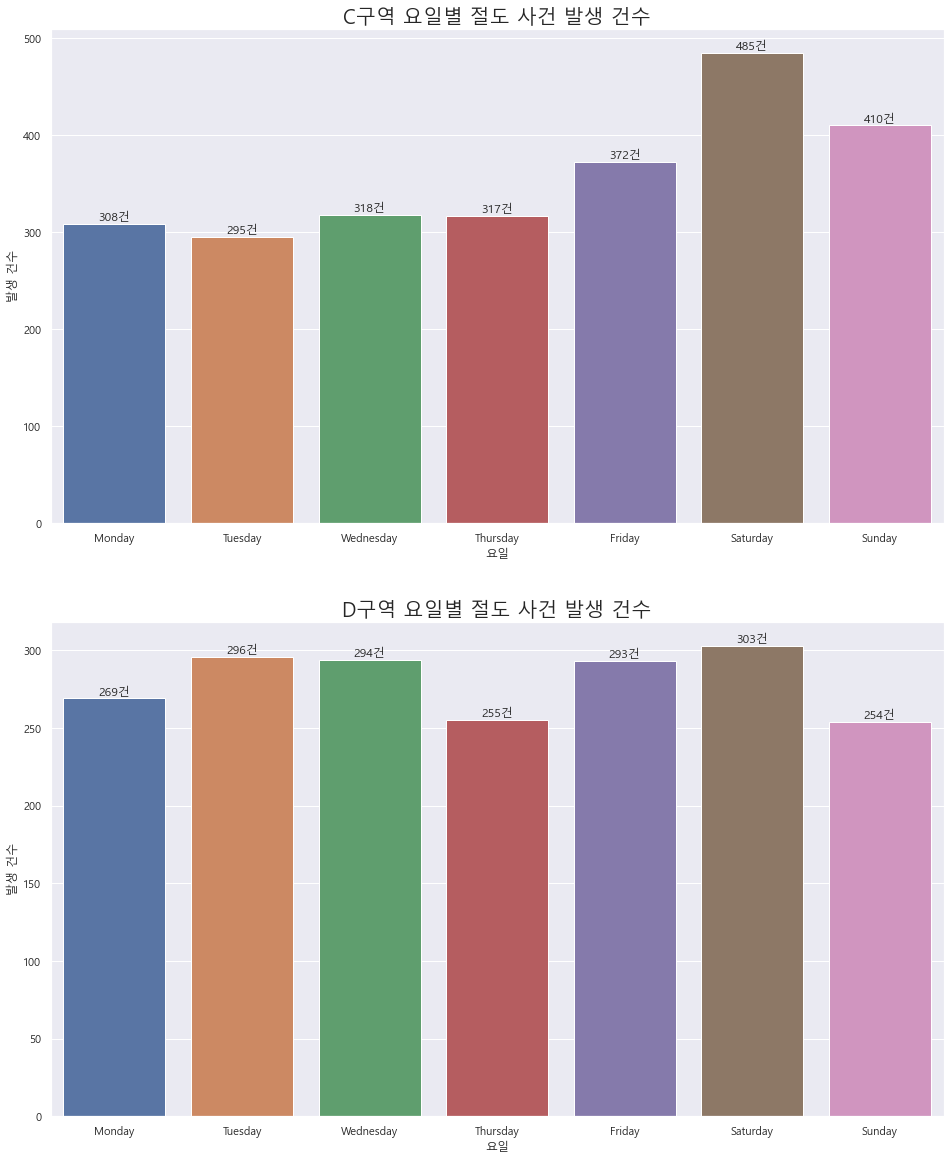

In [63]:
# northern 지역의 시간별 범죄 추이
a = df_northern1.groupby(["DayOfWeek"])[["Dates"]].count()
b = df_northern2.groupby(["DayOfWeek"])[["Dates"]].count()

plt.figure(figsize = (16,20))

# Bryant Street
plt.subplot(2,1,1)
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("C구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

# Powell Street
plt.subplot(2,1,2)
ax = sns.barplot(data = b, x = b.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("D구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

__시간별 분석__

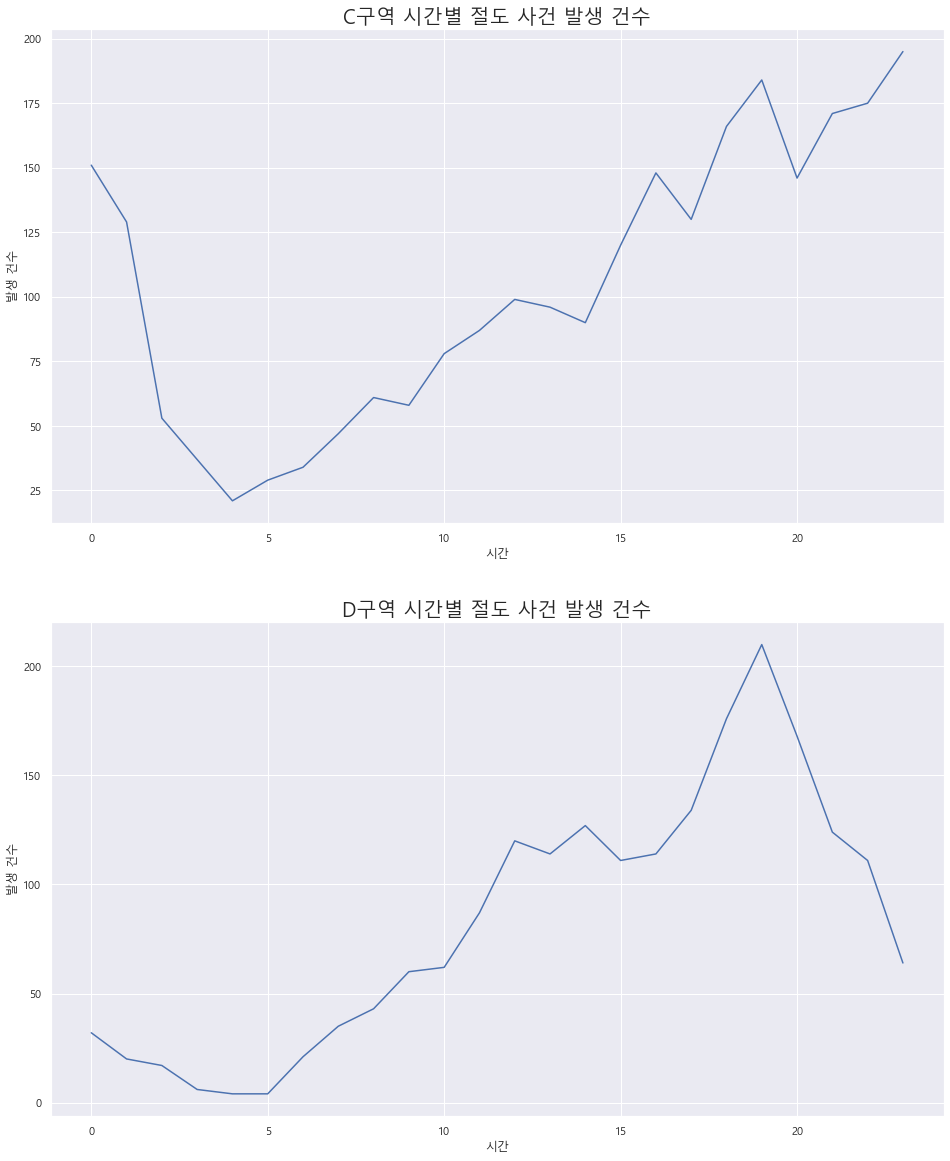

In [64]:
# northern 지역의 시간별 범죄 추이
a = df_northern1.groupby(["Hour"])[["Dates"]].count()
b = df_northern2.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,20))

# Bryant Street
plt.subplot(2,1,1)
ax = sns.lineplot(data = a, x = a.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("C구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

# Powell Street
plt.subplot(2,1,2)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("D구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()

## 3. Central

### a. 관할구역별 분석

__Central지역 요일, 시간별 분석__ 

In [40]:
df_central = df_larceny[df_larceny["PdDistrict"] == "CENTRAL"]
df_central.reset_index(drop = True, inplace = True)


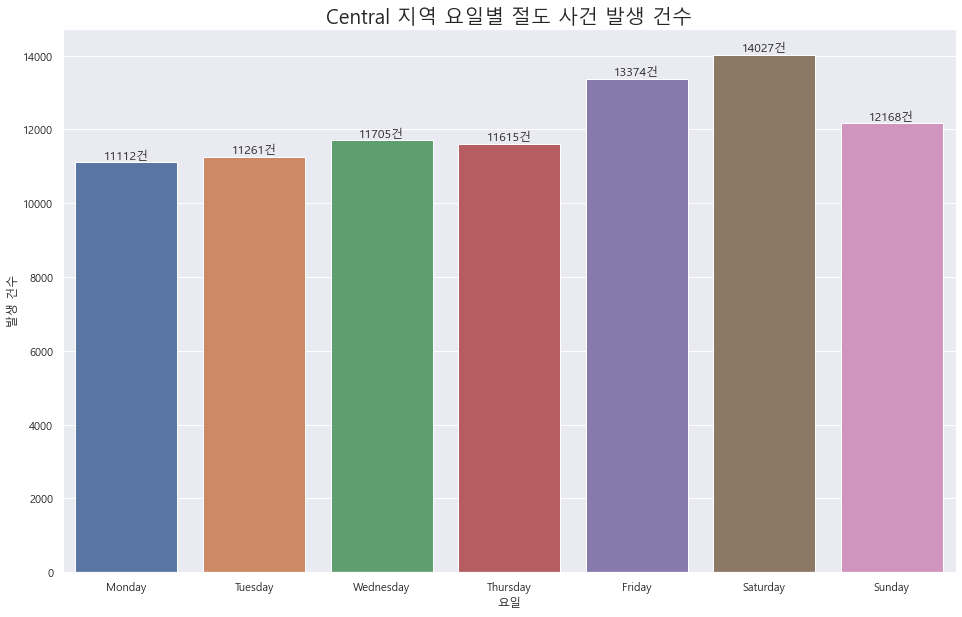

In [84]:
# central 지역의 시간별 범죄 추이
a = df_central.groupby(["DayOfWeek"])[["Dates"]].count()

plt.figure(figsize = (16,10))

ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Central 지역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

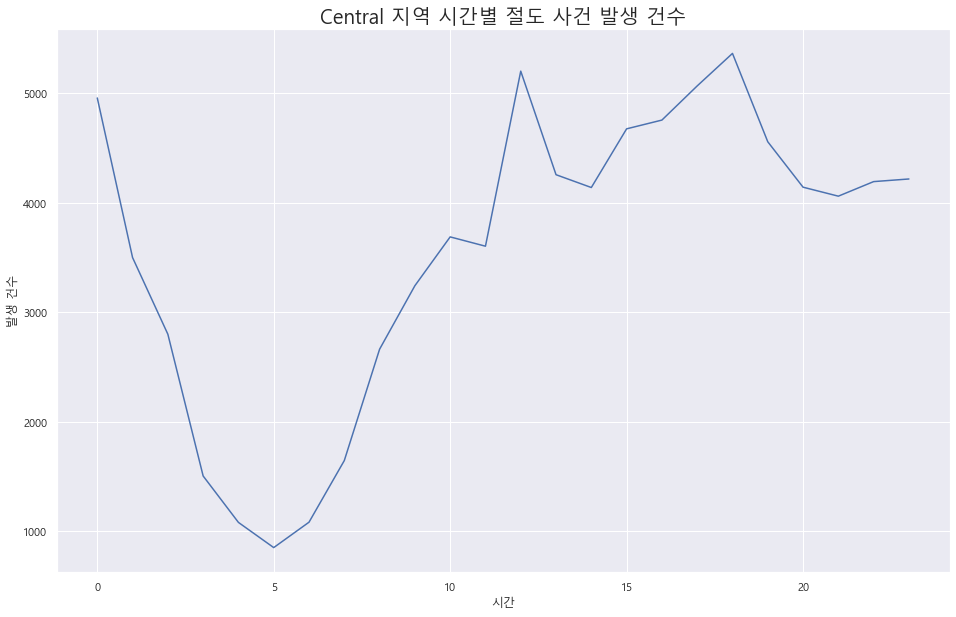

In [85]:
# central 지역의 시간별 범죄 추이
a = df_central.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,10))

sns.lineplot(data = a, x = a.index, y = "Dates")

plt.title("Central 지역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()

### b. 세분화 구역 기준 분석(각 관할별로 100개 구역 분할)

__Central구역 세분화 분석__

In [44]:
df_central = df[df["PdDistrict"] == "CENTRAL"]
df_central.reset_index(drop = True, inplace = True)
df_central["Area"] = area_div(df_central, 100)
crime_heatmap(df_central)

C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\3478004937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_central["Area"] = area_div(df_central, 100)
C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\2233322824.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(zip(df_area_group["Y"], df_area_group["X"], df_area_group["Dates"]),


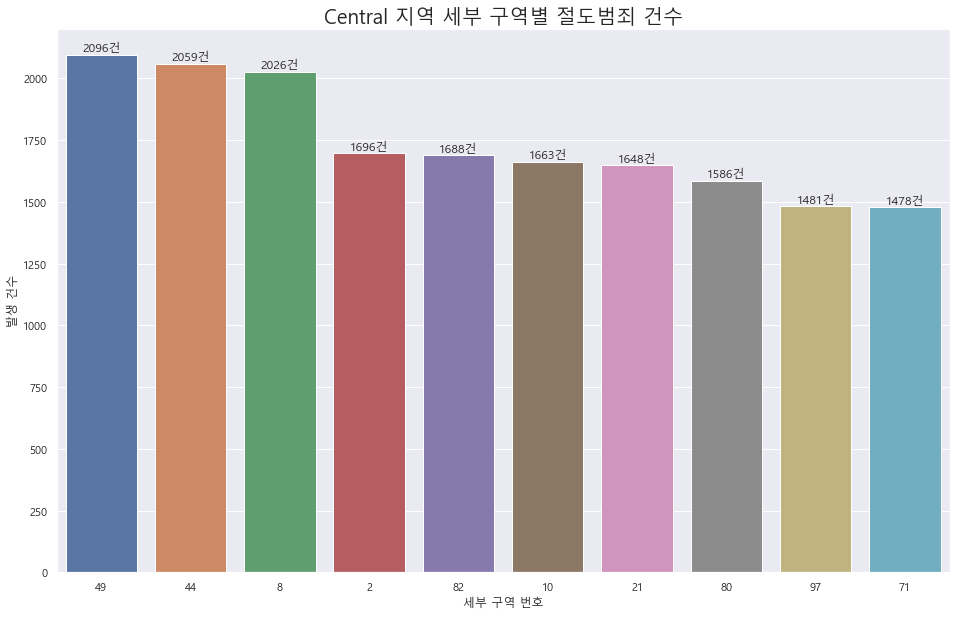

In [86]:
a = df_central.groupby(["Area"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False,inplace = True)
a = a[:10]

plt.figure(figsize = (16, 10))
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = a.index)
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Central 지역 세부 구역별 절도범죄 건수", fontsize = 20)
plt.xlabel("세부 구역 번호")
plt.ylabel("발생 건수")

plt.show()

__Central__
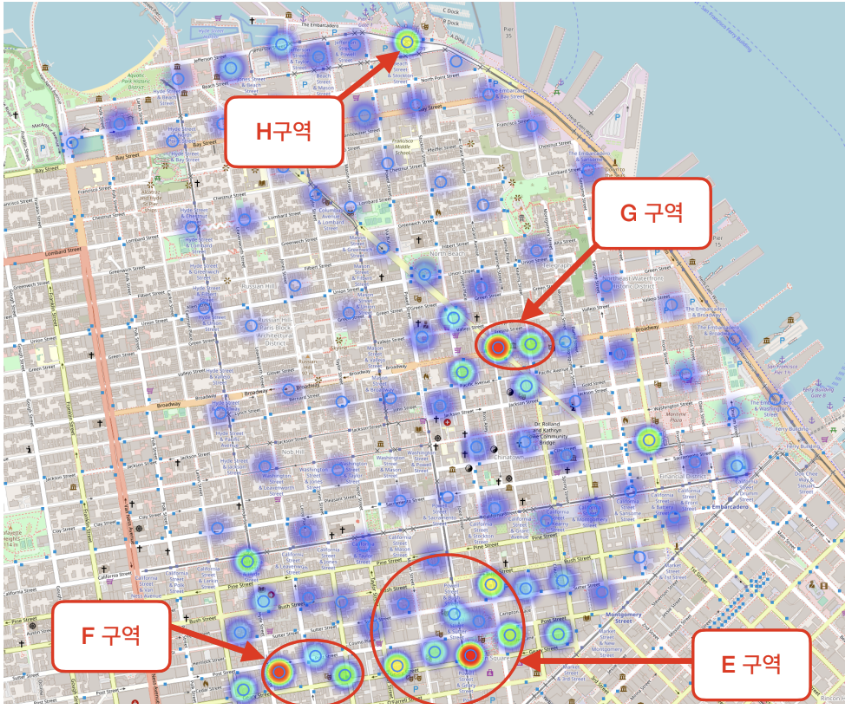

__절도 범죄 우발 거리__
1. E구역 : 49, 2, 82, 80
1. F구역 : 8, 71
1. G구역 : 44, 97
1. H구역 : 10

__요일별 분석__

In [88]:
df_central1 = df_central[(df_central["Area"] == 49) | (df_central["Area"] == 2) | (df_central["Area"] == 82) | (df_central["Area"] == 80)]
df_central1.reset_index(drop = True, inplace = True)

df_central2 = df_central[(df_central["Area"] == 8) | (df_central["Area"] == 71)]
df_central2.reset_index(drop = True, inplace = True)

df_central3 = df_central[(df_central["Area"] == 44) | (df_central["Area"] == 97)]
df_central3.reset_index(drop = True, inplace = True)

df_central4 = df_central[(df_central["Area"] == 10) ]
df_central4.reset_index(drop = True, inplace = True)

# southern 지역의 시간별 범죄 추이
a = df_central1.groupby(["DayOfWeek"])[["Dates"]].count()
b = df_central2.groupby(["DayOfWeek"])[["Dates"]].count()
c = df_central3.groupby(["DayOfWeek"])[["Dates"]].count()
d = df_central4.groupby(["DayOfWeek"])[["Dates"]].count()

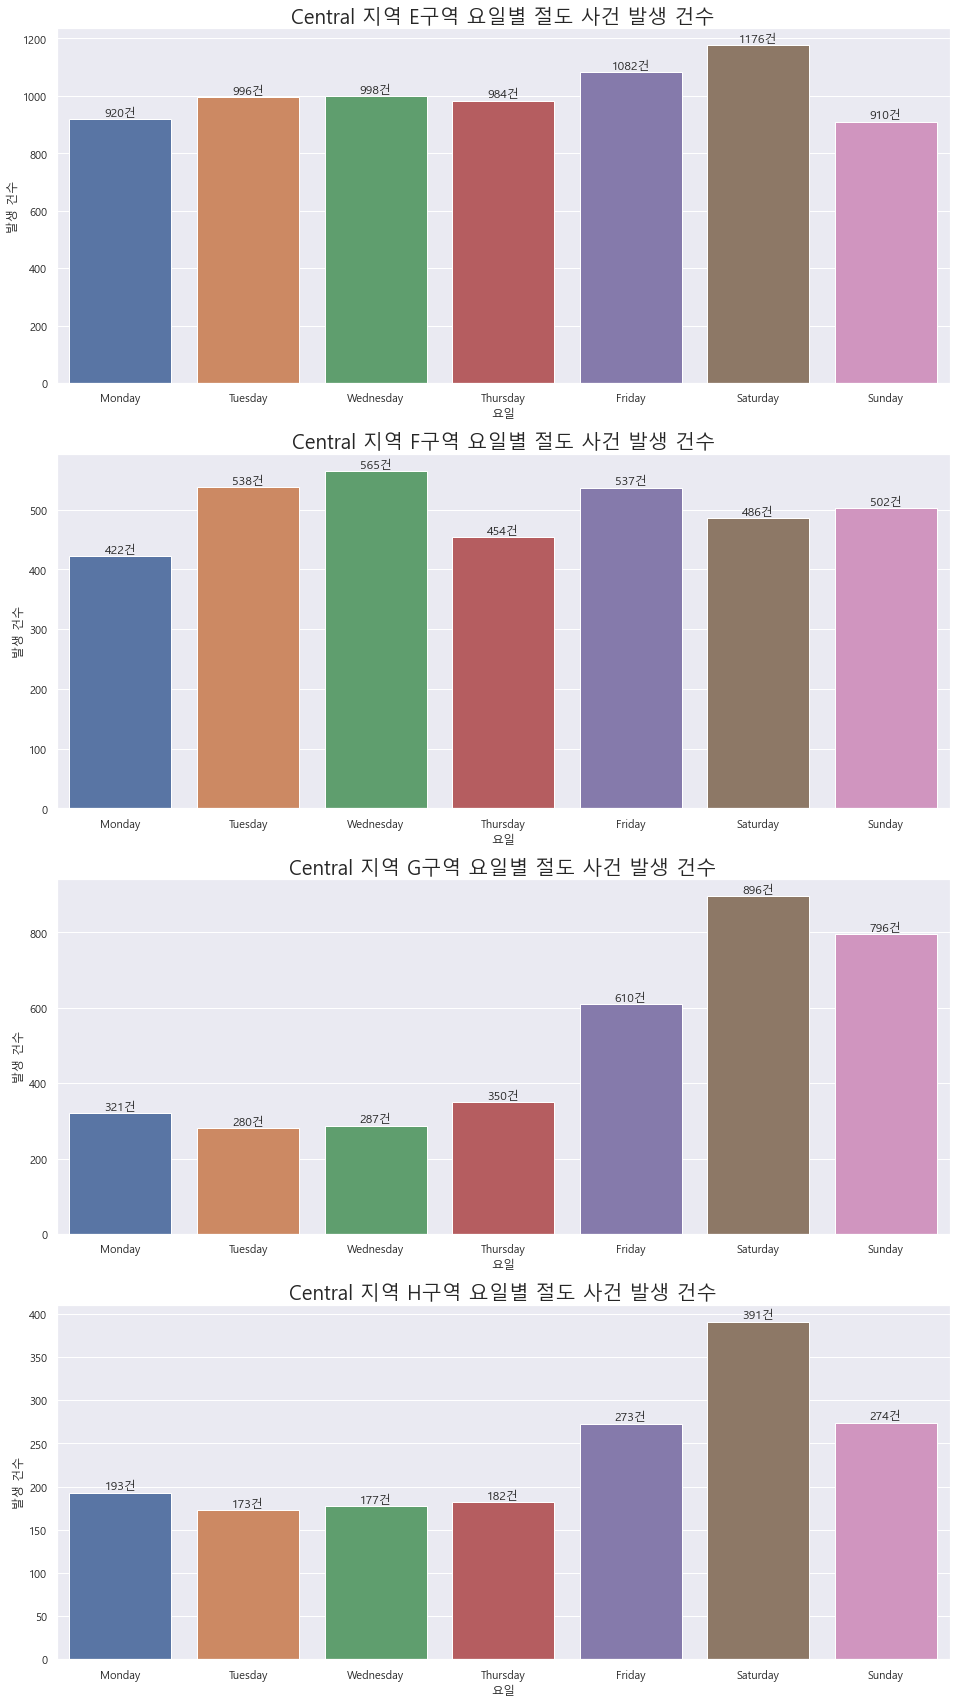

In [89]:
plt.figure(figsize = (16,30))


plt.subplot(4,1,1)
ax1 = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax1.bar_label(ax1.containers[0], fmt='%.0f건')

plt.title("Central 지역 E구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")


plt.subplot(4,1,2)
ax2 = sns.barplot(data = b, x = b.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax2.bar_label(ax2.containers[0], fmt='%.0f건')

plt.title("Central 지역 F구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")


plt.subplot(4,1,3)
ax3 = sns.barplot(data = c, x = c.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax3.bar_label(ax3.containers[0], fmt='%.0f건')

plt.title("Central 지역 G구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")


plt.subplot(4,1,4)
ax4 = sns.barplot(data = d, x = d.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax4.bar_label(ax4.containers[0], fmt='%.0f건')

plt.title("Central 지역 H구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

__시간별 분석__

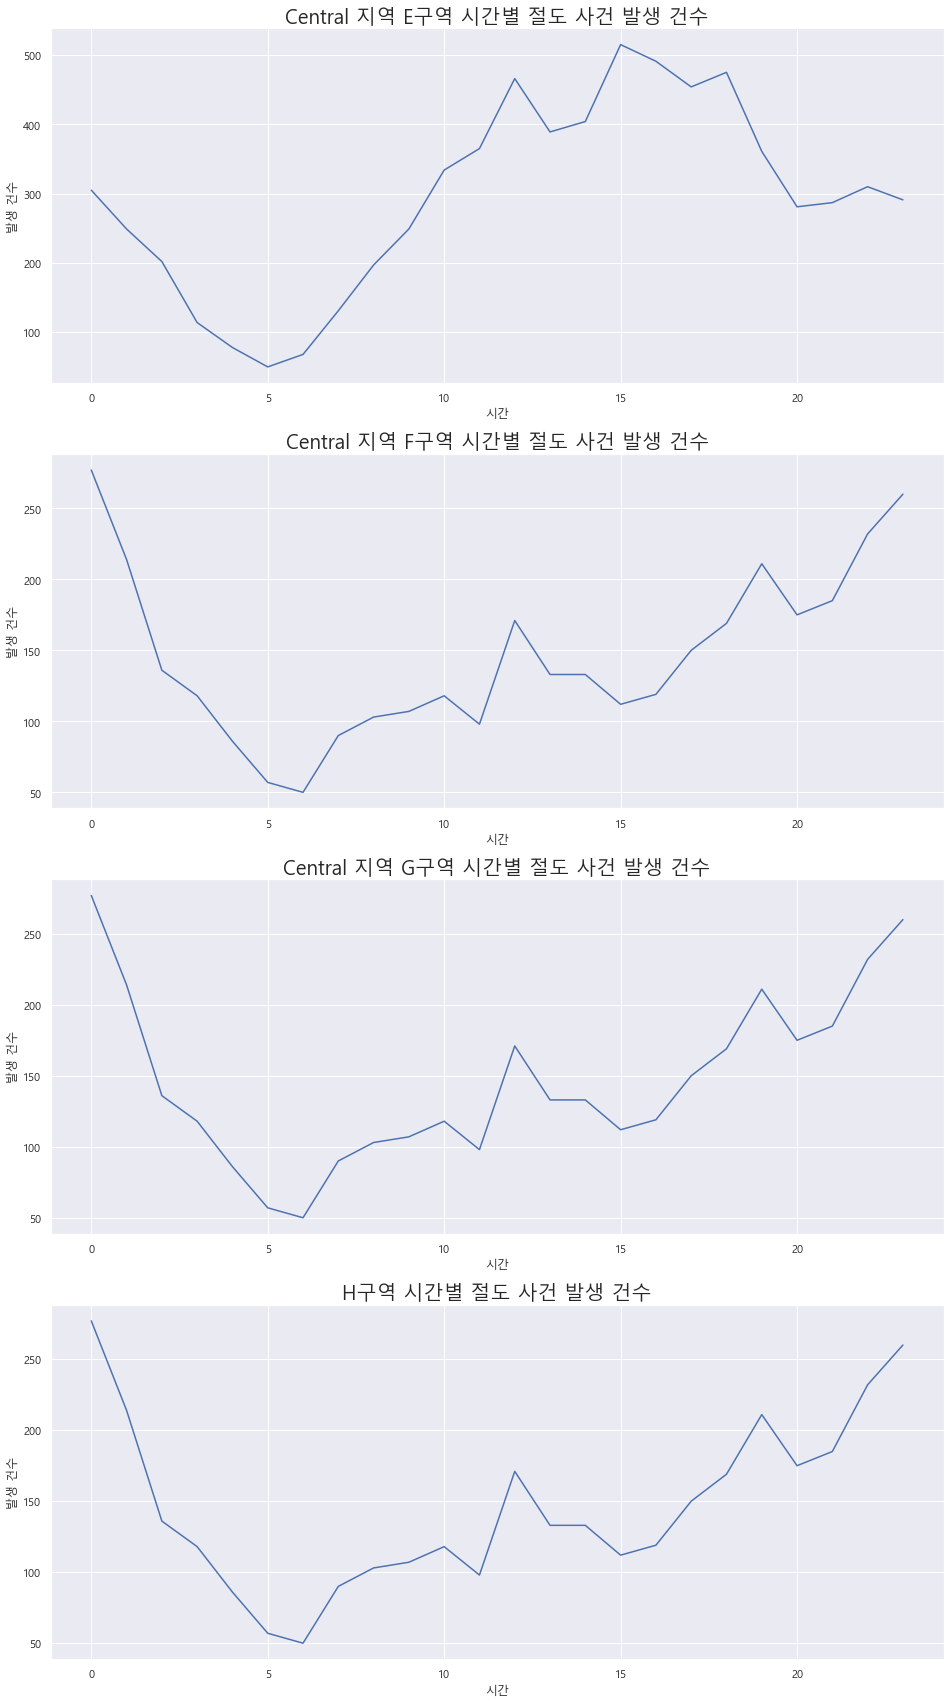

In [90]:
a = df_central1.groupby(["Hour"])[["Dates"]].count()
b = df_central2.groupby(["Hour"])[["Dates"]].count()
c = df_central3.groupby(["Hour"])[["Dates"]].count()
d = df_central4.groupby(["Hour"])[["Dates"]].count()


plt.figure(figsize = (16,30))


plt.subplot(4,1,1)
ax = sns.lineplot(data = a, x = a.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Central 지역 E구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")


plt.subplot(4,1,2)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Central 지역 F구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")


plt.subplot(4,1,3)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Central 지역 G구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")


plt.subplot(4,1,4)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("H구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")


plt.show()

## 4. Mission

### a.관할구역별 분석

__Mission지역 요일, 시간별 분석__

In [49]:
df_mission = df_larceny[df_larceny["PdDistrict"] == "MISSION"]
df_mission.reset_index(drop = True, inplace = True)

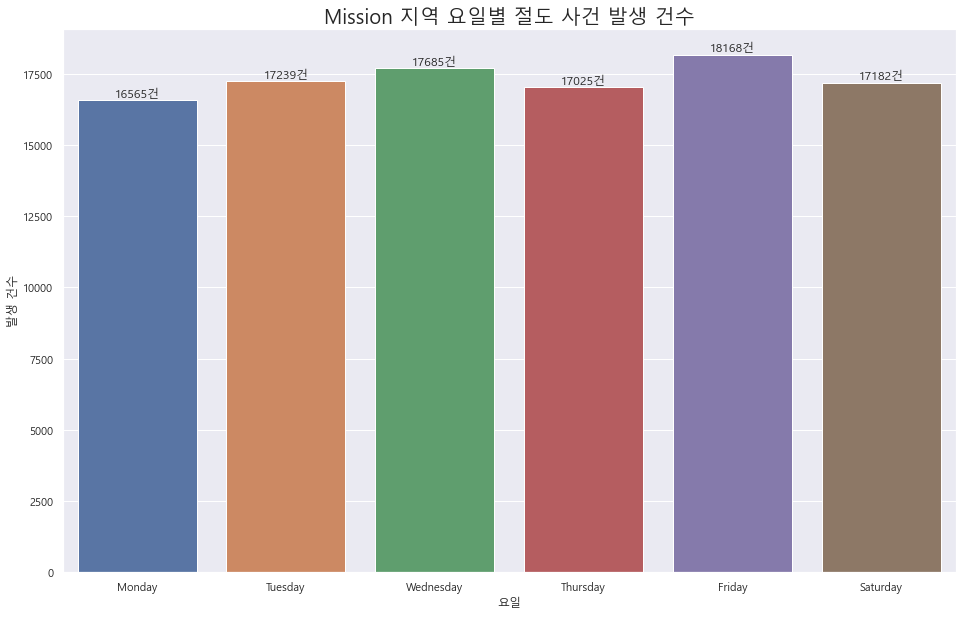

In [91]:
# 지역의 요일별 범죄 추이
a = df_mission.groupby(["DayOfWeek"])[["Dates"]].count()

plt.figure(figsize = (16,10))

ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

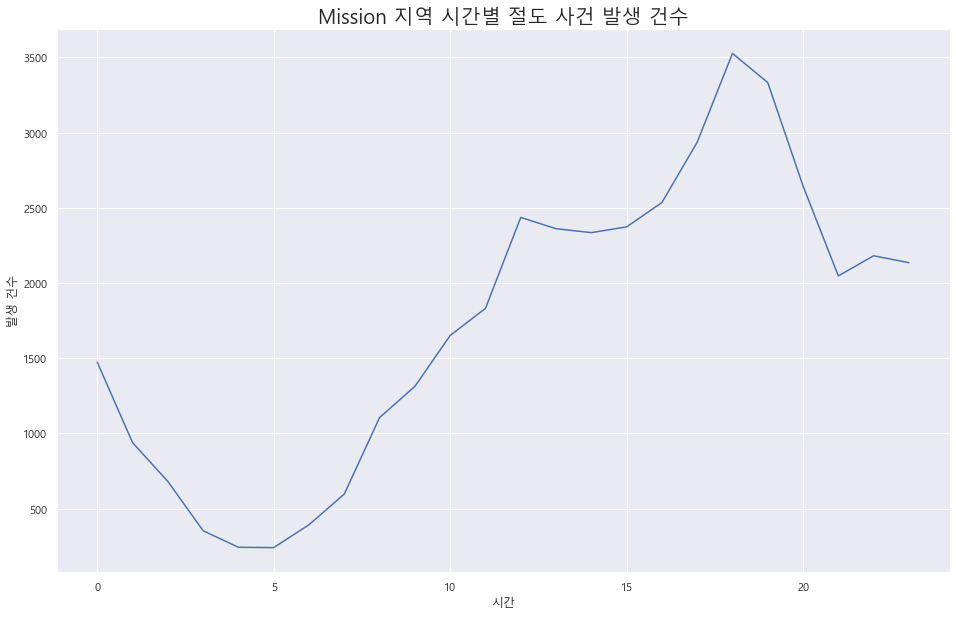

In [92]:
# 시간별
a = df_southern.groupby(["Hour"])[["Dates"]].count()

plt.figure(figsize = (16,10))

sns.lineplot(data = a, x = a.index, y = "Dates")

plt.title("Mission 지역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()


### b. 세분화 구역 기준 분석(각 관할별로 100개 구역 분할)

In [53]:
df_mission = df[df["PdDistrict"] == "MISSION"]
df_mission.reset_index(drop = True, inplace = True)
df_mission["Area"] = area_div(df_mission, 100)
crime_heatmap(df_mission)

C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\3078454224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mission["Area"] = area_div(df_mission, 100)
C:\Users\xowhd\AppData\Local\Temp\ipykernel_12732\2233322824.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(zip(df_area_group["Y"], df_area_group["X"], df_area_group["Dates"]),


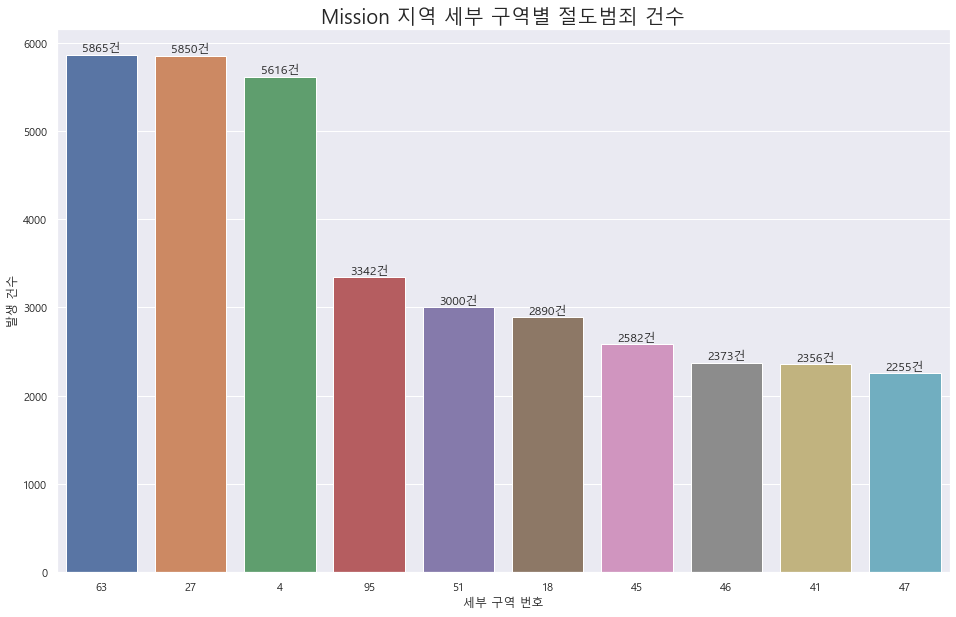

In [93]:
a = df_mission.groupby(["Area"])[["Dates"]].count()
a.sort_values(by = "Dates", ascending = False,inplace = True)
a = a[:10]

plt.figure(figsize = (16, 10))
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = a.index)
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 세부 구역별 절도범죄 건수", fontsize = 20)
plt.xlabel("세부 구역 번호")
plt.ylabel("발생 건수")

plt.show()

__Mission__
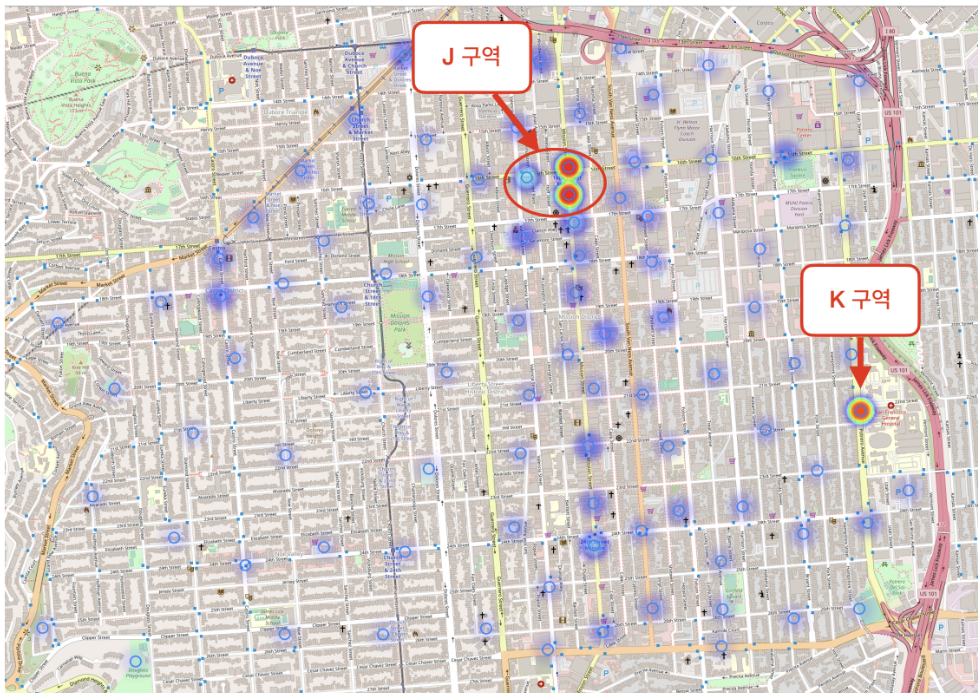

__Mission 지역 절도 범죄 우발 거리__
1. J구역 : 63, 27, 95
1. K구역 : 4

__요일별 분석__

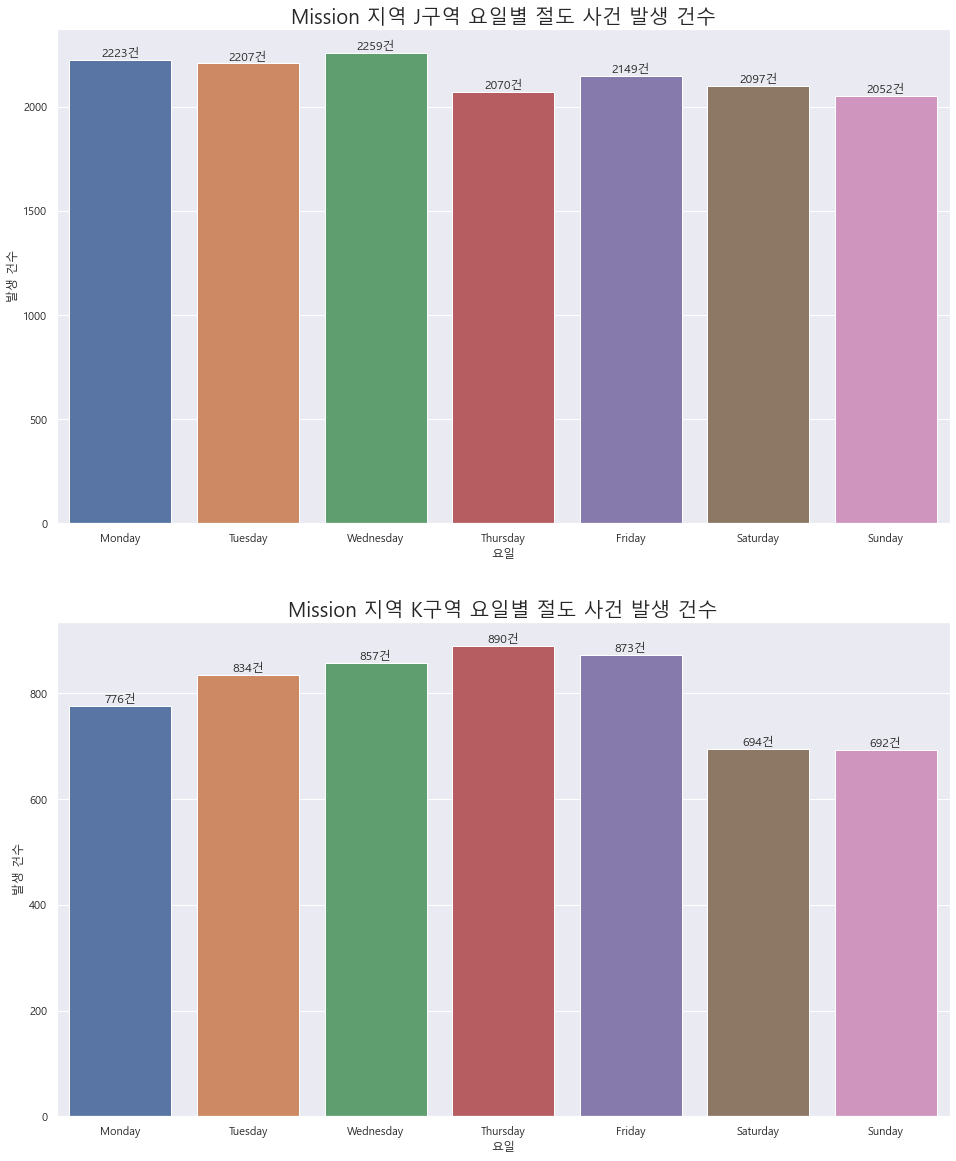

In [95]:
df_mission1 = df_mission[(df_mission["Area"] == 63) | (df_mission["Area"] == 27) | (df_mission["Area"] == 95)]
df_mission1.reset_index(drop = True, inplace = True)

df_mission2 = df_mission[df_mission["Area"] == 4]
df_mission2.reset_index(drop = True, inplace = True)

# southern 지역의 시간별 범죄 추이
a = df_mission1.groupby(["DayOfWeek"])[["Dates"]].count()
b = df_mission2.groupby(["DayOfWeek"])[["Dates"]].count()


plt.figure(figsize = (16,20))


plt.subplot(2,1,1)
ax = sns.barplot(data = a, x = a.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 J구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")


plt.subplot(2,1,2)
ax = sns.barplot(data = b, x = b.index, y = "Dates", order = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 K구역 요일별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("요일")
plt.ylabel("발생 건수")

plt.show()

__시간별 분석__

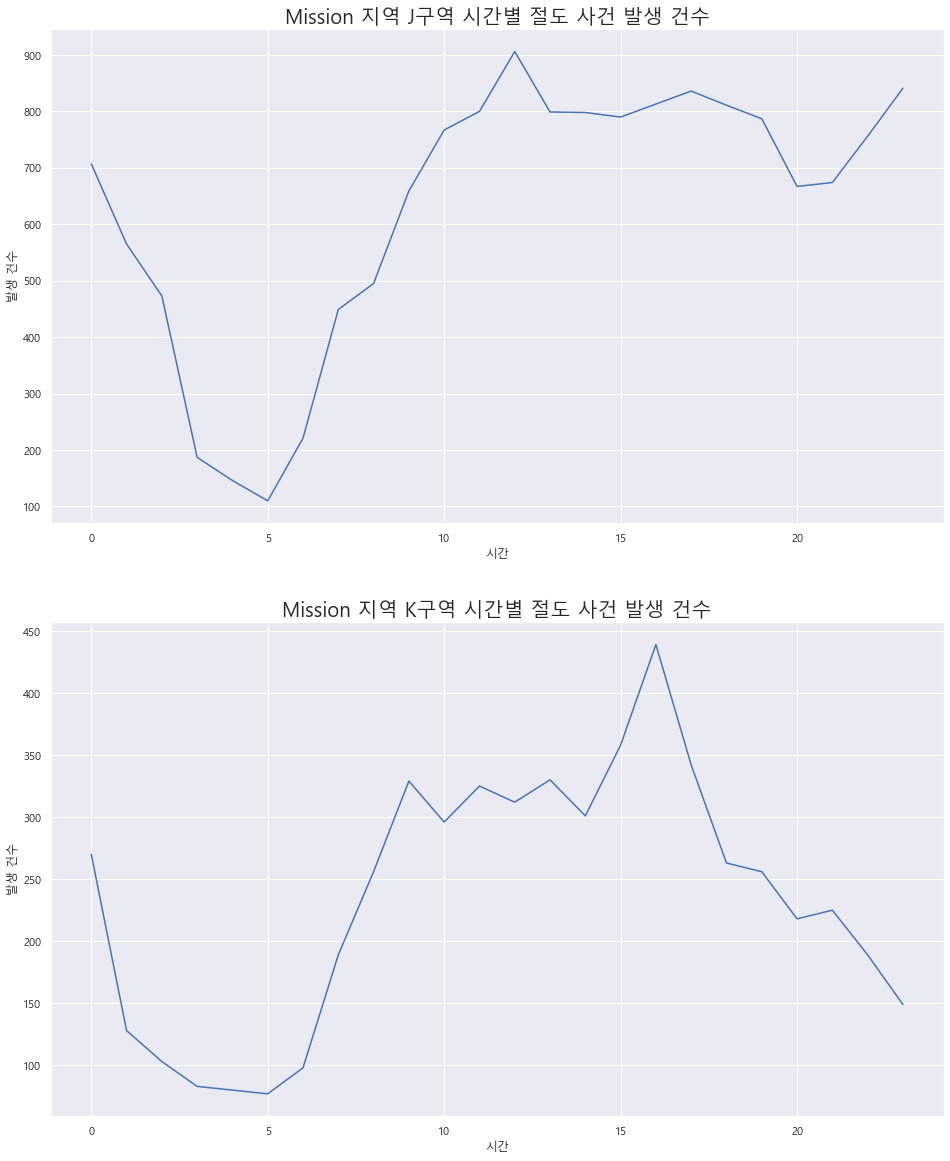

In [97]:
a = df_mission1.groupby(["Hour"])[["Dates"]].count()
b = df_mission2.groupby(["Hour"])[["Dates"]].count()


plt.figure(figsize = (16,20))


plt.subplot(2,1,1)
ax = sns.lineplot(data = a, x = a.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 J구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")


plt.subplot(2,1,2)
ax = sns.lineplot(data = b, x = b.index, y = "Dates")
# ax.bar_label(ax.containers[0], fmt='%.0f건')

plt.title("Mission 지역 K구역 시간별 절도 사건 발생 건수", fontsize = 20)
plt.xlabel("시간")
plt.ylabel("발생 건수")

plt.show()



# 결론

1. 샌프란시스코의 절도 범죄 비율은 __금요일, 토요일과 점심과 저녁 식사 시간에__ 발생비율이 높아진다.
1. 각각의 우발구역의 발생 빈도에 따라 순찰 병력을 효율적으로 배치하는것이 필요하다.